# WTfreq-vs-PRaccum

#!/usr/bin/env python

    File name: WTfreq-vs-PRaccum.ipynb
    Author: Andreas Prein
    E-mail: prein@ucar.edu
    Date created: 26.01.2021
    Date last modified: 26.01.2021

    ############################################################## 
    Purpos:
    Compares seasonal WT frequency with seasonal accumulated Precipitation in catchment
    
    This requires to first run:
    ~/projects/Arizona_WTing/programs/WTing/Centroids-and-Scatterplot.py

    1) read in the WT arrays for focus basis

    2) read in the average daily precipitation in the basins

    3) calculate annual WT day frequency and total precipitation
    
    4) plot scatter plots showing the correlation between WT frequencies and seasonal PR


In [1]:
from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
# from mpl_toolkits import basemap
import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import scipy
import shapefile
import matplotlib.path as mplPath
from matplotlib.patches import Polygon as Polygon2
# Cluster specific modules
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.vq import kmeans2,vq, whiten
from scipy.ndimage import gaussian_filter
import seaborn as sns
# import metpy.calc as mpcalc
import shapefile as shp
import sys
import matplotlib.gridspec as gridspec
# from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile
from scipy import signal
from numpy.linalg import lstsq
import random

def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

### Setup

In [2]:
sPlotDir='/glade/u/home/prein/projects/Arizona_WTing/plots/WTfreq-vs-PRaccum/'
sDataDir='/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/HandK/'
HUC2 = ['1501','1502', '1503', '1504','1505', '1506', '1507', '1810','HUC6-00','HUC6-01','HUC6-02','HUC6-03','HUC6-04','HUC6-05']
DW_Regions=[['1501', '1503', '1507', '1810'], ['1502', '1504','1505', '1506'],['HUC6-00','HUC6-01','HUC6-02','HUC6-05'],['HUC6-03','HUC6-04']]
REGIONS = ['AZ_West','AZ_East','NM_North','NM_South']
sMonths='6-7-8-9-10'
Season = 'JJASO'
YYYY_stamp='1982-2018'
iNrOfExtremes = 13514

VarComp = [['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850']]

### Load the Eucledian Distances and the Daily Precipitation for each Region

In [3]:
for re in range(len(HUC2)):
    sRegion=HUC2[re]
    ss='-'
    VarsJoint=ss.join(VarComp[re])
    sClusterSave='/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/HandK/Clusters'+str(iNrOfExtremes)+'_'+sRegion+'_'+YYYY_stamp+'_'+VarsJoint+'_'+Season
    with open(sClusterSave, 'rb') as handle:
        DATA = pickle.load(handle)
    grEucledianDist = DATA['grEucledianDist']['Full']
    rgdTime = DATA['rgdTime']
    Peval = DATA['Peval']
    ClusterArray = DATA['grClustersFin']['Full'][1]
    LonWT = DATA['LonWT']
    LatWT = DATA['LatWT']
    if re == 0:
        PR_All = np.zeros((len(rgdTime),len(HUC2))); PR_All[:]=np.nan
        PR_All_GC = np.zeros((len(rgdTime), 10000, len(HUC2))); PR_All[:]=np.nan
        Cluster_All = np.copy(PR_All)
    
    sPRsave='/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/HandK/Precipitation-Records_'+str(iNrOfExtremes)+'_'+sRegion+'_'+YYYY_stamp+'_'+sMonths+'.npz'
    npzfile = np.load(sPRsave)
    rgrPRrecords=npzfile['rgrPRrecords']
    
    PR_All[:,re] = rgrPRrecords
    PR_All_GC[:,:Peval.shape[1],re]=Peval
    
    # sort WTs from dry to wet
    TEST = np.nanmean(DATA['Peval'], axis=1)
    WT_PR = [np.nanmean(TEST[DATA['grClustersFin']['Full'][1] == wt]) for wt in range(np.max(DATA['grClustersFin']['Full'][1])+1)]
    iWT_sort = np.argsort(WT_PR)
    ClusterTMP = np.copy(ClusterArray); ClusterTMP[:] = np.nan
    for wt in range(len(iWT_sort)):
        ClusterTMP[ClusterArray == wt] = np.where(iWT_sort == wt)[0][0]
    Cluster_All[:,re] = ClusterTMP


### Merge the basins into main clusters

In [4]:
WTsFIN = np.zeros((PR_All.shape[0],len(DW_Regions))); WTsFIN[:] = np.nan
PR_FIN = np.zeros((PR_All.shape[0],len(DW_Regions))); PR_FIN[:] = np.nan
for re in range(len(DW_Regions)):
    iClusterReg = HUC2.index(DW_Regions[re][0])
    WTsFIN[:,re] = Cluster_All[:,iClusterReg]
    matching = [HUC2.index(DW_Regions[re][ii]) for ii in range(len(DW_Regions[re]))]
    PR_FIN[:,re] = np.nanmean(PR_All_GC[:,:,matching],axis=(1,2))

In [5]:
# calculate annual and seasonal frequency of WTs and amount of precipitation
YEARS = np.unique(rgdTime.year)
AnnualPR = np.zeros((len(YEARS), len(DW_Regions))); AnnualPR[:] = np.nan
Annual_WT = np.zeros((len(YEARS), int(WTsFIN.max()+1), len(DW_Regions))); Annual_WT[:] = np.nan
MonthPR = np.zeros((len(YEARS), 5, len(DW_Regions))); MonthPR[:] = np.nan
Month_WT = np.zeros((len(YEARS), 5, int(WTsFIN.max()+1), len(DW_Regions))); Month_WT[:] = np.nan
Season=[6,7,8,9,10]
for re in range(len(DW_Regions)):
    for yy in range(len(YEARS)):
        DDact = (rgdTime.year == YEARS[yy])
        AnnualPR[yy,re] = np.mean(PR_FIN[DDact,re])
        WT_yy = WTsFIN[DDact,re]
        for wt in range(3):
            Annual_WT[yy,wt,re] = np.sum(WT_yy == wt)
        for mo in range(len(Season)):
            DDact = (rgdTime.year == YEARS[yy]) & (rgdTime.month == Season[mo])
            MonthPR[yy,mo,re] = np.mean(PR_FIN[DDact,re])
            WT_mm = WTsFIN[DDact,re]
            for wt in range(3):
                Month_WT[yy,mo,wt,re] = np.sum(WT_mm == wt)
            

In [6]:
### Save the precip data for further processing in other programs
np.savez('PRISM_Monsoon-basins_PR.npz',
        AnnualPR=AnnualPR,
        YEARS=YEARS,
        MonthPR=MonthPR,
        Season=Season)

### Plot and save scatter plots

        Plot map to: /glade/u/home/prein/projects/Arizona_WTing/plots/WTfreq-vs-PRaccum/WTfreq-vs-PRaccum.png


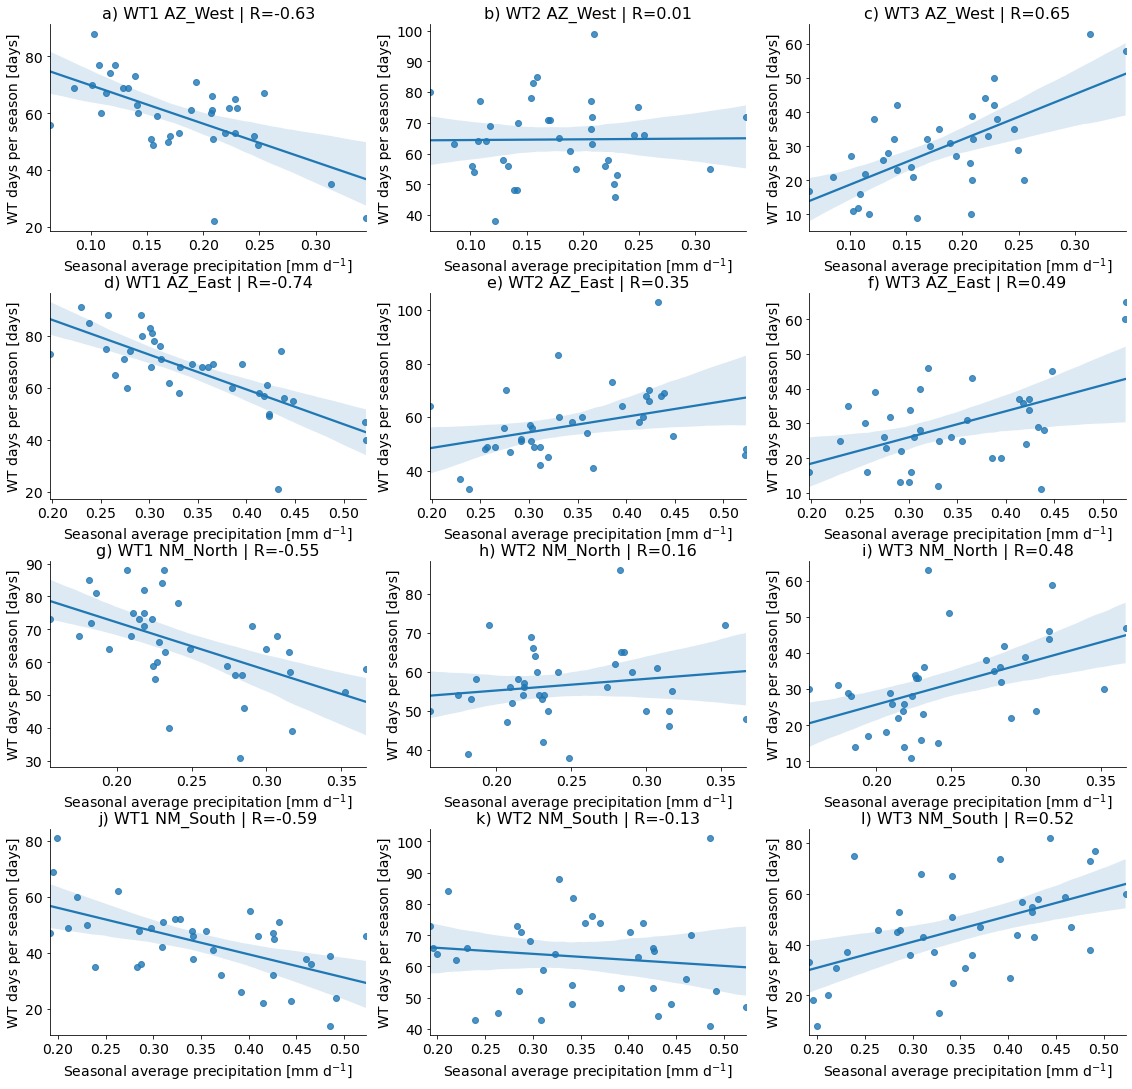

In [7]:
import seaborn as sns

fig = plt.figure(figsize=(18, 18))
plt.rcParams.update({'font.size': 14})
gs2 = gridspec.GridSpec(ncols=3, nrows=len(DW_Regions), figure=fig)
gs2.update(left=0.15, right=0.98,
           bottom=0.17, top=0.95,
           wspace=0.2, hspace=0.3)

rgsLableABC=list(string.ascii_lowercase)+list(string.ascii_uppercase)
for re in range(len(DW_Regions)):
    for wt in range(int(WTsFIN.max()+1)):
        ax = fig.add_subplot(gs2[re,wt])
        sns.regplot(x=AnnualPR[:,re], y=Annual_WT[:,wt,re])
        CorrCoef = scipy.stats.pearsonr(AnnualPR[:,re], Annual_WT[:,wt,re])[0]
        plt.xlabel('Seasonal average precipitation [mm d$^{-1}$]')
        plt.ylabel('WT days per season [days]')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
#         plt.xlim(0, 0.7)
        plt.title(rgsLableABC[wt+re*3]+') WT'+str(wt+1)+' '+REGIONS[re]+' | R='+str(np.round(CorrCoef,2)), fontsize=16)
        
# Save the plot
sPlotFile=sPlotDir
sPlotName= 'WTfreq-vs-PRaccum.png'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName)

### Save data for Erin

In [10]:
Month_PR = np.reshape(MonthPR, (MonthPR.shape[0]*MonthPR.shape[1],MonthPR.shape[2]))
YYYYMM = np.array([[YEARS[yy]*100+Season[mm] for mm in range(len(Season))] for yy in range(len(YEARS))]).astype(int).flatten()
DATA = np.append(YYYYMM[:,None],Month_PR, axis=1)
grDATA = {}
grDATA['YYYYMM'] = DATA[:,0]
grDATA['AZ_West']  = DATA[:,1]
grDATA['AZ_East']  = DATA[:,2]
grDATA['NM_North']  = DATA[:,3]
grDATA['NM_South']  = DATA[:,4]
df = pd.DataFrame(grDATA)
df.to_csv('PRISM_monsoon-season-precipitation_1982-2018.csv', index=False) 


Month_WT_flat = np.reshape(Month_WT, (Month_WT.shape[0]*Month_WT.shape[1],Month_WT.shape[2],Month_WT.shape[3]))

for re in range(len(REGIONS)):
    DATA = Month_WT_flat[:,:,re]
    grDATA = {}
    grDATA['YYYYMM'] = YYYYMM.astype(int)
    grDATA['dry']  = DATA[:,0].astype(int)
    grDATA['normal']  = DATA[:,1].astype(int)
    grDATA['monsoon']  = DATA[:,2].astype(int)
    df = pd.DataFrame(grDATA)
    df.to_csv('WT-frequency_'+REGIONS[re]+'_monsoon-season_1982-2018.csv', index=False) 

In [11]:
Month_WT_flat.shape

(185, 3, 4)

### FIG 2 FOR PUBLICTATION

        Plot map to: /glade/u/home/prein/projects/Arizona_WTing/plots/Fig02/Fig02.pdf


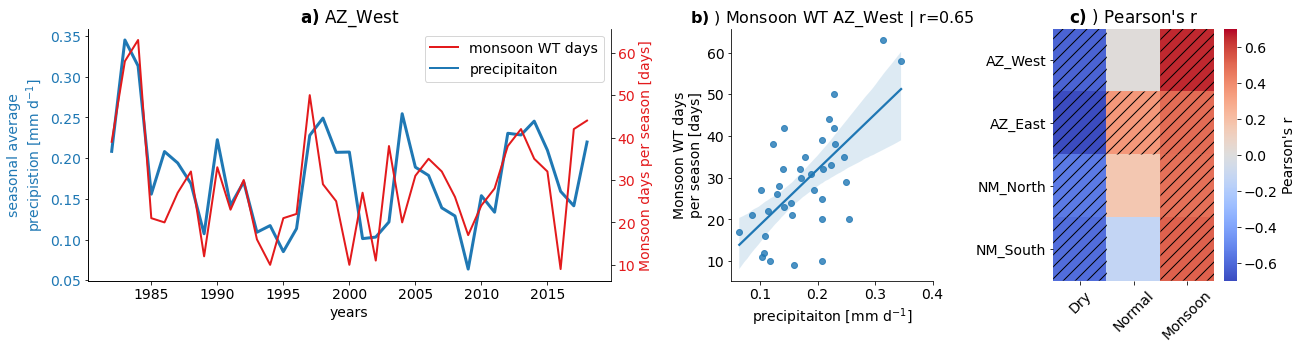

In [16]:
fig = plt.figure(figsize=(18, 5))
plt.rcParams.update({'font.size': 14})
gs2 = gridspec.GridSpec(ncols=4, nrows=1, figure=fig)
gs2.update(left=0.06, right=0.96,
           bottom=0.2, top=0.9,
           wspace=0.6, hspace=0.3)

# ------ START WITH THE TIME SERIES PLOT ------
ax = fig.add_subplot(gs2[0,:2])

re=0 # AZ_West
wt=2 # monsoon

ax.plot(YEARS, AnnualPR[:,re], color='#1f78b4', label='precipitaiton', lw=3)
ax.tick_params(axis='y', labelcolor='#1f78b4')
ax.set_ylabel('seasonal average\nprecipistion [mm d$^{-1}$]', color='#1f78b4')
ax.set_xlabel('years')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax2 = ax.twinx()
ax2.plot(YEARS, Annual_WT[:,wt,re], color='#e31a1c', label='monsoon WT days', lw=2)
ax2.tick_params(axis='y', labelcolor='#e31a1c')
ax2.set_ylabel('Monsoon days per season [days]', color='#e31a1c')
# ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax2.plot([1990,1990], [10,10], color='#1f78b4', label='precipitaiton', lw=2)
plt.legend()

plt.title(r"$\bf{" + str(rgsLableABC[0])+ ")}$ "+REGIONS[re])


# ------ SCATTER PLOT FOR TIME SERIES ------
ax = fig.add_subplot(gs2[0,2])
sns.regplot(x=AnnualPR[:,re], y=Annual_WT[:,wt,re])
CorrCoef = scipy.stats.pearsonr(AnnualPR[:,re], Annual_WT[:,wt,re])[0]
plt.xlabel('precipitaiton [mm d$^{-1}$]')
plt.ylabel('Monsoon WT days\nper season [days]')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlim(0.05, 0.4)
plt.title(r"$\bf{" + str(rgsLableABC[1])+ ")}$ "+') Monsoon WT '+REGIONS[re]+' | r='+str(np.round(CorrCoef,2)), fontsize=16)



# # ------ HEATMAP SHOWING THE CORRELATION COEFFICIENCE PER WT AND BASIN ------
ax = fig.add_subplot(gs2[0,3])
PEARSON = np.zeros((4,3,2)); PEARSON[:]=np.nan
for re in range(len(DW_Regions)):
    for wt in range(int(WTsFIN.max()+1)):
        FIN = ~np.isnan(AnnualPR[:,re]) * ~np.isnan(Annual_WT[:,wt,re])
        if np.sum(FIN) > 2:
            PEARSON[re,wt,:] = scipy.stats.pearsonr(AnnualPR[FIN,re], Annual_WT[FIN,wt,re])   
        
plt.title(r"$\bf{" + str(rgsLableABC[2])+ ")}$ "+') Pearson\'s r')
sns.heatmap(PEARSON[:,:,0], cmap='coolwarm', vmin=-0.7, vmax=0.7, 
                    cbar_kws={'label': "Pearson\'s r"})

# Show significance
x= np.array(range(4))
y= np.array(range(5))
zm = np.ma.masked_greater(PEARSON[:,:,1], 0.05)
plt.pcolor(x, y, zm, hatch='//', alpha=0.)
    
Basins=['AZ_West', 'AZ_East', 'NM_North','NM_South'] 
ax.set_yticklabels(Basins, rotation = 0)
ax.set_xticklabels(['Dry','Normal','Monsoon'], rotation = 45)

# Save the plot
sPlotDir='/glade/u/home/prein/projects/Arizona_WTing/plots/Fig02/'
sPlotFile=sPlotDir
sPlotName= 'Fig02.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName)

In [9]:
PEARSON[:,:,1] < 0.05

NameError: name 'PEARSON' is not defined

In [10]:
np.arange(3+1)

array([0, 1, 2, 3])

In [11]:
np.array(HUC2)[matching]

array(['HUC6-03', 'HUC6-04'], dtype='<U7')

In [12]:
TEST = np.nanmean(DATA['Peval'], axis=1)
WT_PR = [np.nanmean(TEST[DATA['grClustersFin']['Full'][1] == wt]) for wt in range(np.max(DATA['grClustersFin']['Full'][1])+1)]

In [13]:
WT_PR

[0.22563366943817903, 3.1404157139559925, 1.2361327573978909]

In [14]:
TEST

array([0.00000000e+00, 0.00000000e+00, 2.43566179e-03, ...,
       2.17683825e-02, 3.37909467e-01, 2.98863143e+00])

### calculate statistics for all possible permutations

In [15]:
DATA['PRanom']

{'SS1': 0.10067504621872267,
 'SS2': 0.2629193061058209,
 'Full': 0.8841249830916011}

In [16]:
# basin average PR

In [17]:
ANOMALY = np.zeros((len(DW_Regions),len(DW_Regions))); ANOMALY[:] = np.nan
IvI = np.copy(ANOMALY)
for re0 in range(len(DW_Regions)):
    for re1 in range(len(DW_Regions)):
        PR_Centroids_test = np.array([np.nanmean(PR_All[Cluster_All[:,re0] == ce,re1]) for ce in np.unique(Cluster_All[:,re0])])
#         print(PR_Centroids_test)
#         print(np.nanmean(PR_All[:,re1]))
        ANOMALY[re0,re1] = np.mean(np.abs(1-(PR_Centroids_test/np.nanmean(PR_All[:,re1]))))
        IntraClusterSTD = np.nanstd(PR_All[:,re1], axis=0)
        InterClusterSTD = np.array([np.std(PR_All[Cluster_All[:,re0] == ce,re1], axis=0) for ce in np.unique(Cluster_All[:,re0])])
        IvI[re0,re1] = IntraClusterSTD/np.mean(InterClusterSTD)

NameError: name 'sRegNames' is not defined

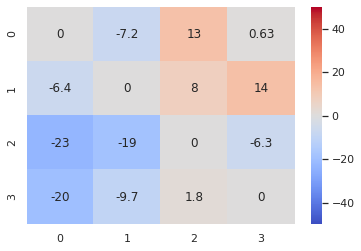

In [18]:
import seaborn as sns; sns.set()
AnomDiff = np.zeros((len(DW_Regions),len(DW_Regions))); AnomDiff[:] = np.nan
for re1 in range(len(DW_Regions)):
    for re2 in range(len(DW_Regions)):
        AnomDiff[re1,re2] = ((ANOMALY[re1,re2]-ANOMALY[re2,re2])/ANOMALY[re2,re2])*100


ax=sns.heatmap(AnomDiff[:,:], cmap='coolwarm', vmin=-50, vmax=50, annot = True)
ax.set_yticklabels(sRegNames, rotation=0)
ax.set_xticklabels(sRegNames, rotation=90)

In [ ]:
import seaborn as sns; sns.set()
ax=sns.heatmap(ANOMALY[:,:], cmap='coolwarm', vmin=0.5, vmax=1.4, annot = True)
ax.set_yticklabels(sRegNames, rotation=0)
ax.set_xticklabels(sRegNames, rotation=90)

In [ ]:
import seaborn as sns; sns.set()
IvIDiff = np.zeros((len(DW_Regions),len(DW_Regions))); IvIDiff[:] = np.nan
for re in range(len(DW_Regions)):
    IvIDiff[re,:] = ((IvI[re,:]-IvI[re,re])/IvI[re,re])*100
    
ax=sns.heatmap(IvIDiff[:,:], cmap='coolwarm', vmin=-5, vmax=5, annot = True)
ax.set_yticklabels(sRegNames, rotation=0)
ax.set_xticklabels(sRegNames, rotation=90)

### plot results on map

In [ ]:
from mpl_toolkits import basemap
plt.rcParams.update({'font.size': 13})
rgsLableABC=list(string.ascii_lowercase)

fig = plt.figure(figsize=(21,6))

gs1 = gridspec.GridSpec(2,8)
gs1.update(left=0.09, right=0.98,
           bottom=0.07, top=0.93,
           wspace=0.25, hspace=0.25)

Skores =['changes in anomaly\nskill score [%]', 'changes in variability\nskill score [%]']
for sk in range(2):
    for re1 in range(len(DW_Regions)):
        # ======================================
        # frequency changes in clustered events
        ax = plt.subplot(gs1[sk,re1])
        Stat = Skores[sk]
        COLORS = ['#a50026','#d73027','#f46d43','#fdae61','#fee090','#ffffbf','#e0f3f8','#abd9e9','#74add1','#4575b4','#313695'][::-1]
        levels=np.linspace(-20,20,len(COLORS))
        plt.axis('off')
        m = Basemap(projection='cea',\
                    llcrnrlat= 30.5 ,urcrnrlat=38.5,\
                    llcrnrlon=-117.5,urcrnrlon=-107,resolution='i', fix_aspect=False) #, epsg=4269)
        for re2 in range(len(DW_Regions)):
            if sk == 0:
                ScoresACT = AnomDiff[re1,re2]
            else:
                ScoresACT = IvIDiff[re1,re2]

            sf = shp.Reader('/glade/campaign/mmm/c3we/prein/Shapefiles/HUC4/NHD_H_'+DW_Regions[re2]+'_HU4_Shape/Shape/WBDHU4')
            df = read_shapefile(sf)
            for sf in range(df.shape[0]):
                ctr = df['coords'][sf]
                if len(ctr) > 10000:
                    ctr=np.array(ctr)[::100,:] # carsen the shapefile accuracy
                else:
                    ctr=np.array(ctr)
            try:
                iCol=np.where(levels < ScoresACT)[0][-1]
            except:
                if ScoresACT < levels[0]:
                    iCol=0
                else:
                    iCol=len(colors)-1
            # add shapefile of catchment
            XX,YY=m(ctr[:,0], ctr[:,1])
            if re1 == re2:
                m.plot(XX,YY, c='r', lw=2)
            else:
                m.plot(XX,YY, c='k', lw=2)

            ax.fill(XX,YY, COLORS[iCol], alpha=0.7, zorder=2)

        plt.title(r"$\bf{" + str(rgsLableABC[re1*2])+ "}$ "+DW_Regions[re1])

        m.drawcountries(color='#636363', zorder=10)
        m.drawstates(color='#636363', zorder=10)
        #     m.drawrivers(color='dodgerblue',linewidth=0.5,zorder=10)  
        m.fillcontinents(color='#f0f0f0', zorder=1)
        m.drawcoastlines(color='#636363', zorder=10)
    # add colorbar
    a = np.array([[levels[0],levels[-1]]])
    img = plt.contourf([[0,0],[0,0]], [[0,0],[0,0]], colors=COLORS,levels=levels, extend='both')
    # img.cmap.set_over('#a50026')
    # img.cmap.set_under('#313695')
    if sk == 0:
        CbarAx = axes([0.02, 0.55, 0.01, 0.4])
    else:
        CbarAx = axes([0.02, 0.05, 0.01, 0.4])
    cb = colorbar(img, cax = CbarAx, orientation='vertical', ticks=levels, extend='both')
    cb.set_label(Stat, fontsize=14)

# Save the plot
# plt.show()
sPlotFile=sPlotDir
sPlotName= 'Dependence-Of_Regions.png'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName)